# LAB 4.4 - Semantic segmentation

The labs require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [28]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [251]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L04.04", varname="student");

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import tensorflow as tf
%matplotlib inline
from IPython.display import Image
tf.__version__

## TASK 1: Naive CNN for segmentation

Genera un modelo de segmentación semántica con la siguiente arquitectura:

Generate a semantic segmentation model with the following architecture:

- The first two convolutional blocks from `UNet` (`c1/p1`, `c2/p2`, with the same `Dropout` and `MaxPooling2D`)
- A dense layer with 1000 neurons, `relu` activation, and a `Dropout` with `0.3`
- A pre-output dense layer with `IMG_HEIGHT*IMG_HEIGHT` neurons and `sigmoid` activation.
- A `Reshape` layer as final output to side `IMG_HEIGHT, IMG_HEIGHT, 1`


Using the initial `Lambda` layer, and with the `Adam` over `rmse` you should get exactly the following model configuration:

        Model: "model"
        _________________________________________________________________
        Layer (type)                 Output Shape              Param #   
        =================================================================
        input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
        _________________________________________________________________
        lambda (Lambda)              (None, 128, 128, 3)       0         
        _________________________________________________________________
        c1_conv1 (Conv2D)            (None, 128, 128, 16)      448       
        _________________________________________________________________
        c1_dropout (Dropout)         (None, 128, 128, 16)      0         
        _________________________________________________________________
        c1_conv2 (Conv2D)            (None, 128, 128, 16)      2320      
        _________________________________________________________________
        c1_maxpool (MaxPooling2D)    (None, 64, 64, 16)        0         
        _________________________________________________________________
        c2_conv1 (Conv2D)            (None, 64, 64, 32)        4640      
        _________________________________________________________________
        c2_dropout (Dropout)         (None, 64, 64, 32)        0         
        _________________________________________________________________
        c2_conv2 (Conv2D)            (None, 64, 64, 32)        9248      
        _________________________________________________________________
        c2_maxpool (MaxPooling2D)    (None, 32, 32, 32)        0         
        _________________________________________________________________
        flatten (Flatten)            (None, 32768)             0         
        _________________________________________________________________
        dense1000 (Dense)            (None, 1000)              32769000  
        _________________________________________________________________
        dense1000_dropout (Dropout)  (None, 1000)              0         
        _________________________________________________________________
        dense_128x128 (Dense)      (None, 16384)             16400384  
        _________________________________________________________________
        reshape_128x128x1 (Reshape)  (None, 128, 128, 1)       0         
        =================================================================
        Total params: 49,186,040
        Trainable params: 49,186,040
        Non-trainable params: 0
        _________________________________________________________________


If you train your model with the Data Science Bowl segmentation images and labels at the corresponding UNet notebook in this course, you should get an output similar to the following one on these specific images on the **VALIDATION** set.

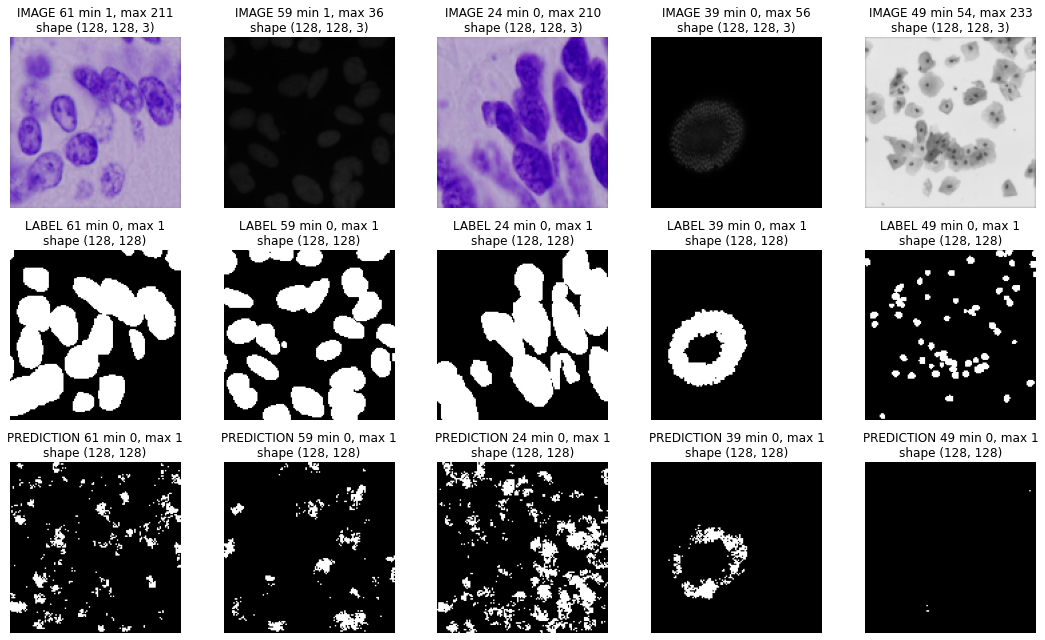

In [4]:

Image("local/imgs/unet-modelA.png", width=800)


In [ ]:
def get_model_A(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3):
    from tensorflow.keras.layers import Dense, Input, Dropout, Lambda
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
    from tensorflow.keras import Model    
    
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    # YOUR CODE HERE
    outputs = ... # YOUR CODE HERE
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mse')
    
    return model


inspect your model structure

In [208]:
m = get_model_A()
m.summary()

**Registra tu solución en linea**

In [260]:
student.submit_task(namespace=globals(), task_id='T1');

## TASK 2: Naive CNN for segmentation with skipped connections

Add two layers at the end of the previous model so that the output is constructed by:
    
- concatenating the input image channels to the output of the `Reshape` layer
- performing a `1x1` convolution on the previous concatenation

You should have a model such as 

        Model: "model_1"
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
        __________________________________________________________________________________________________
        lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
        __________________________________________________________________________________________________
        c1_conv1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
        __________________________________________________________________________________________________
        c1_dropout (Dropout)            (None, 128, 128, 16) 0           c1_conv1[0][0]                   
        __________________________________________________________________________________________________
        c1_conv2 (Conv2D)               (None, 128, 128, 16) 2320        c1_dropout[0][0]                 
        __________________________________________________________________________________________________
        c1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           c1_conv2[0][0]                   
        __________________________________________________________________________________________________
        c2_conv1 (Conv2D)               (None, 64, 64, 32)   4640        c1_maxpool[0][0]                 
        __________________________________________________________________________________________________
        c2_dropout (Dropout)            (None, 64, 64, 32)   0           c2_conv1[0][0]                   
        __________________________________________________________________________________________________
        c2_conv2 (Conv2D)               (None, 64, 64, 32)   9248        c2_dropout[0][0]                 
        __________________________________________________________________________________________________
        c2_maxpool (MaxPooling2D)       (None, 32, 32, 32)   0           c2_conv2[0][0]                   
        __________________________________________________________________________________________________
        flatten (Flatten)               (None, 32768)        0           c2_maxpool[0][0]                 
        __________________________________________________________________________________________________
        dense1000 (Dense)               (None, 1000)         32769000    flatten[0][0]                    
        __________________________________________________________________________________________________
        dense1000_dropout (Dropout)     (None, 1000)         0           dense1000[0][0]                  
        __________________________________________________________________________________________________
        dense_128x128x3 (Dense)         (None, 16384)        16400384    dense1000_dropout[0][0]          
        __________________________________________________________________________________________________
        reshape_128x128x3 (Reshape)     (None, 128, 128, 1)  0           dense_128x128x3[0][0]            
        __________________________________________________________________________________________________
        concatenate (Concatenate)       (None, 128, 128, 4)  0           reshape_128x128x3[0][0]          
                                                                         input_2[0][0]                    
        __________________________________________________________________________________________________
        conv_1x1 (Conv2D)               (None, 128, 128, 1)  5           concatenate[0][0]                
        ==================================================================================================
        Total params: 49,186,045
        Trainable params: 49,186,045
        Non-trainable params: 0
        __________________________________________________________________________________________________
        
     
If you train your model with the Data Science Bowl segmentation images and labels at the corresponding UNet notebook in this course, you should get an output similar to the following one on these specific images on the **VALIDATION** set.

Observe how the model cannot abstract shapes and basically does a color filter. The semantic information upsampled is weaker than the skipped connections.


You might get a different output, depending on which kind of source images your model focuses on (black, white or pink background)

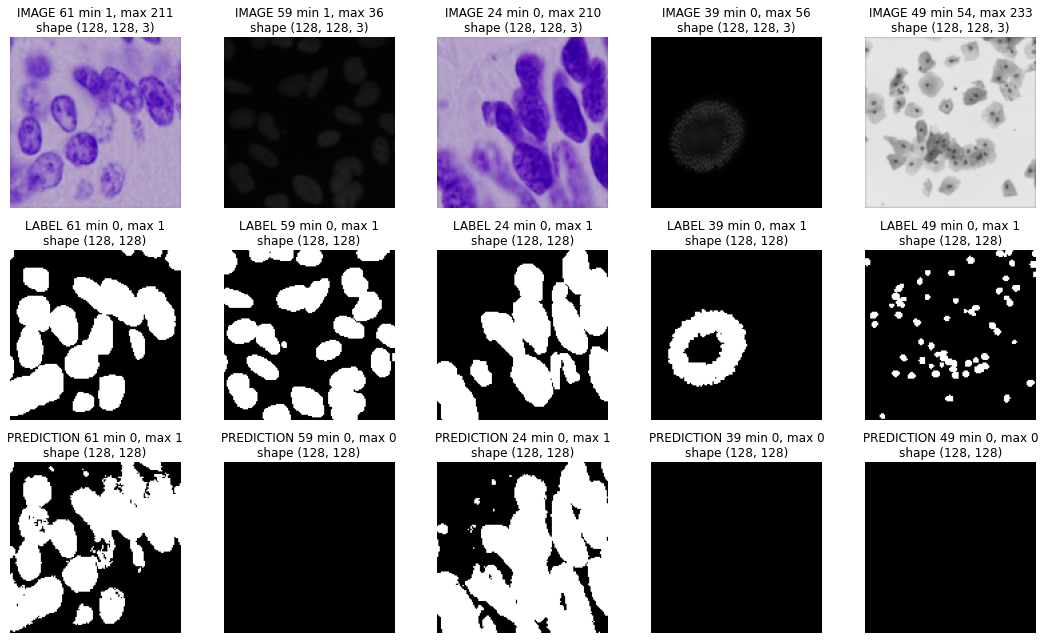

In [210]:

Image("local/imgs/unet-modelB.png", width=800)


In [ ]:
def get_model_B(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3):
    
    from tensorflow.keras.layers import Dense, Input, Dropout, Lambda, concatenate
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
    from tensorflow.keras import Model    
    
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    # YOUR CODE HERE
    outputs = ... # YOUR CODE HERE
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mse')
    
    return model



inspect the structure of your model

In [211]:
m = get_model_B()
m.summary()

**Registra tu solución en linea**

In [264]:
student.submit_task(namespace=globals(), task_id='T2');

## TASK 3: UNET no skipped connections

Create a UNET model just like in the corresponding notebook in this course, but **WITHOUT** the skipped connections.

Your model structure should be as follows


        model = get_model_UNET_no_skipped()
        model.summary()
        Model: "model_6"
        _________________________________________________________________
        Layer (type)                 Output Shape              Param #   
        =================================================================
        input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
        _________________________________________________________________
        lambda_6 (Lambda)            (None, 128, 128, 3)       0         
        _________________________________________________________________
        conv2d (Conv2D)              (None, 128, 128, 16)      448       
        _________________________________________________________________
        dropout (Dropout)            (None, 128, 128, 16)      0         
        _________________________________________________________________
        conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
        _________________________________________________________________
        max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
        _________________________________________________________________
        conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
        _________________________________________________________________
        dropout_1 (Dropout)          (None, 64, 64, 32)        0         
        _________________________________________________________________
        conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
        _________________________________________________________________
        max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
        _________________________________________________________________
        conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
        _________________________________________________________________
        dropout_2 (Dropout)          (None, 32, 32, 64)        0         
        _________________________________________________________________
        conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
        _________________________________________________________________
        max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
        _________________________________________________________________
        conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
        _________________________________________________________________
        dropout_3 (Dropout)          (None, 16, 16, 128)       0         
        _________________________________________________________________
        conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
        _________________________________________________________________
        max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
        _________________________________________________________________
        conv2d_8 (Conv2D)            (None, 8, 8, 256)         295168    
        _________________________________________________________________
        dropout_4 (Dropout)          (None, 8, 8, 256)         0         
        _________________________________________________________________
        conv2d_9 (Conv2D)            (None, 8, 8, 256)         590080    
        _________________________________________________________________
        conv2d_transpose (Conv2DTran (None, 16, 16, 128)       131200    
        _________________________________________________________________
        conv2d_10 (Conv2D)           (None, 16, 16, 128)       147584    
        _________________________________________________________________
        dropout_5 (Dropout)          (None, 16, 16, 128)       0         
        _________________________________________________________________
        conv2d_11 (Conv2D)           (None, 16, 16, 128)       147584    
        _________________________________________________________________
        conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        32832     
        _________________________________________________________________
        conv2d_12 (Conv2D)           (None, 32, 32, 64)        36928     
        _________________________________________________________________
        dropout_6 (Dropout)          (None, 32, 32, 64)        0         
        _________________________________________________________________
        conv2d_13 (Conv2D)           (None, 32, 32, 64)        36928     
        _________________________________________________________________
        conv2d_transpose_2 (Conv2DTr (None, 64, 64, 32)        8224      
        _________________________________________________________________
        conv2d_14 (Conv2D)           (None, 64, 64, 32)        9248      
        _________________________________________________________________
        dropout_7 (Dropout)          (None, 64, 64, 32)        0         
        _________________________________________________________________
        conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
        _________________________________________________________________
        conv2d_transpose_3 (Conv2DTr (None, 128, 128, 16)      2064      
        _________________________________________________________________
        conv2d_16 (Conv2D)           (None, 128, 128, 16)      2320      
        _________________________________________________________________
        dropout_8 (Dropout)          (None, 128, 128, 16)      0         
        _________________________________________________________________
        conv2d_17 (Conv2D)           (None, 128, 128, 16)      2320      
        _________________________________________________________________
        conv2d_18 (Conv2D)           (None, 128, 128, 1)       17        
        =================================================================
        Total params: 1,745,265
        Trainable params: 1,745,265
        Non-trainable params: 0
        _________________________________________________________________
        
        
If you train your model with the Data Science Bowl segmentation images and labels at the corresponding UNet notebook in this course, you should get an output similar to the following one on these specific images on the **VALIDATION** set.

Observe that the segmentations are generally OK, but luck the detail on the UNet model **WITH** skipped connections.

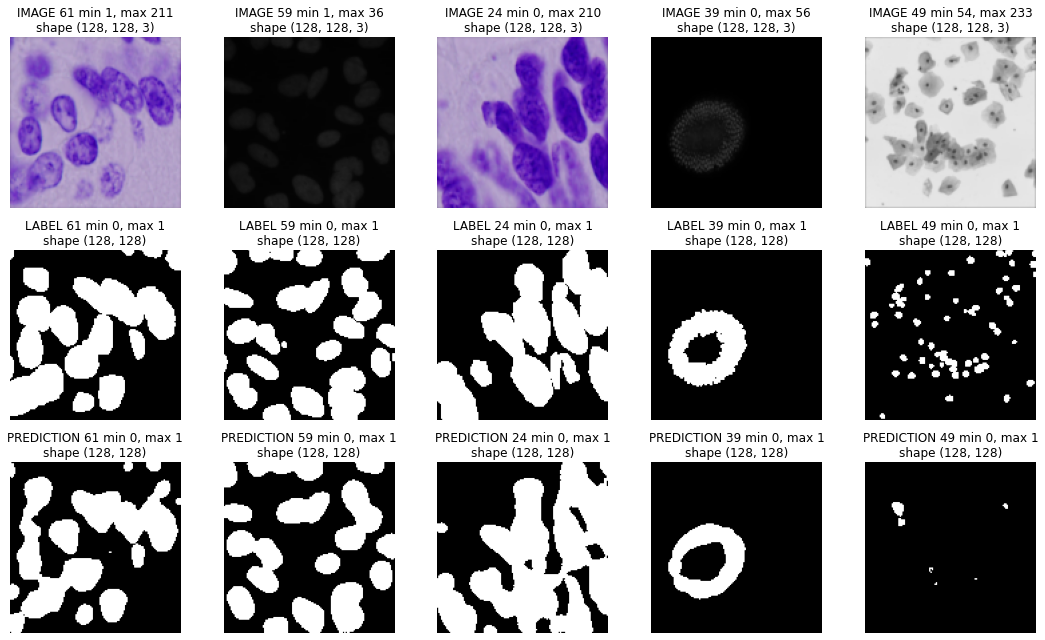

In [18]:

Image("local/imgs/unet-noskipped.png", width=800)


In [ ]:
def get_model_UNET_no_skipped(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3):
    
    from tensorflow.keras.layers import Dense, Input, Dropout, Lambda, concatenate
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose
    from tensorflow.keras import Model    

    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    # YOUR CODE HERE
    
    outputs = ... # YOUR CODE HERE

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

inspect the structure of your model

In [286]:
m = get_model_UNET_no_skipped()
m.summary()

**Registra tu solución en linea**

In [269]:
student.submit_task(namespace=globals(), task_id='T3');